In [ ]:
import torch, torchvision
from torchvision import datasets, models, transforms
import torchvision.transforms as transforms
from torch.optim import lr_scheduler # Bỏ dòng này (không dùng đến)
import numpy as np
import matplotlib.pyplot as plt
import time

In [ ]:
import torch
torch.cuda.empty_cache() # Empty_cache để xóa bộ nhớ cache trong gpu

# GPU's name
print(torch.cuda.get_device_name(0))
device = torch.device("cuda")

Tesla T4


# Data preparation

In [ ]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5), #Q: Giải thích tham số p ?
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) #Q: giải thích ý nghĩa tham số (0.5, 0.5, 0.5)
    ]),
    'test': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]),
}


batch_size = 32

#Q: Giải thích khác nhau giữa trainset và trainloader ?
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=data_transforms['train'])
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=data_transforms['test'])
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=True, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:14<00:00, 11632118.86it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


## Data Visualization

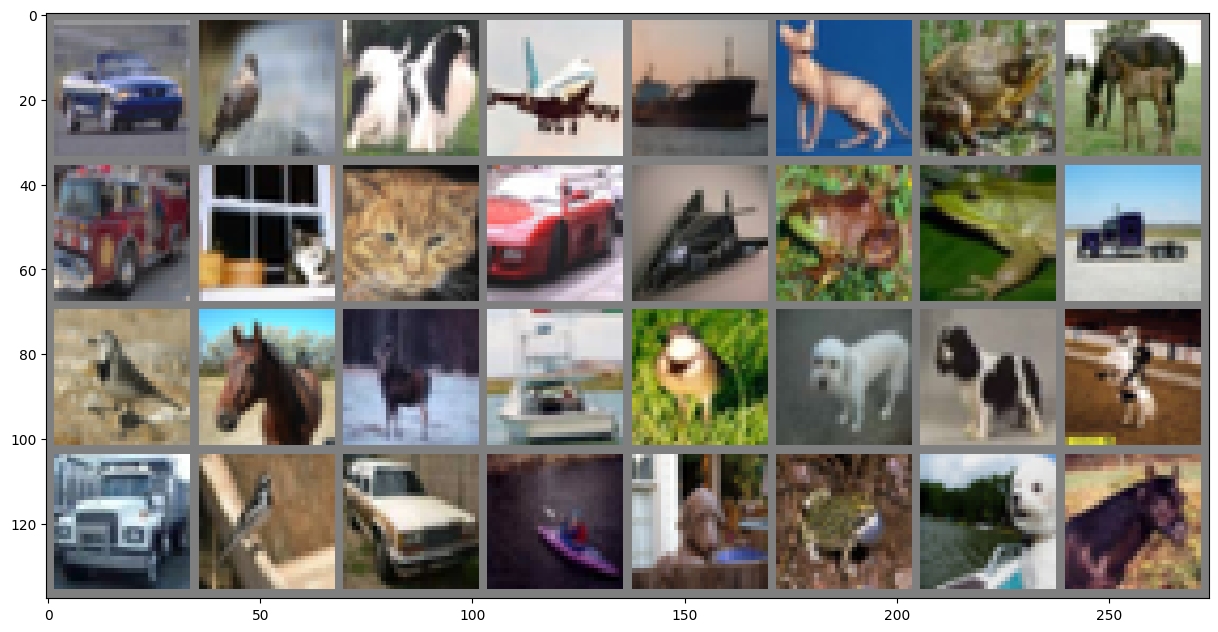

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(15, 15))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(''.join('%13s' % classes[labels[j]] for j in range(8)))
print(''.join('%13s' % classes[labels[j]] for j in range(8,16)))
print(''.join('%13s' % classes[labels[j]] for j in range(16,24)))
print(''.join('%13s' % classes[labels[j]] for j in range(24,32)))

# Utils

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import time, datetime

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)


def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

          car         bird          dog        plane         ship          cat         frog        horse
        truck          cat          cat          car        plane         frog         frog        truck
         bird        horse         deer         ship         bird          dog          dog        horse
        truck         bird          car         ship          dog         frog          dog        horse


### Config

In [ ]:
#CIFAR10
NUM_CLASSES = 10

# Model (AlexNet)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class AlexNet(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES):
        super(AlexNet, self).__init__()
        # Input is image with size 3x32x32
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 2 * 2, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), 256 * 2 * 2)
        x = self.classifier(x)
        return x

model = AlexNet()
model.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4,  betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-6)

# Training & Testing

In [ ]:
model.train()

t0 = time.time()
training_stats = []

n_epochs = 50
trainloader=trainloader
for epoch in range(n_epochs):  # loop over the dataset multiple times

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch + 1, n_epochs))
    print('Training...')
    t1 = time.time()

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        if i % 500 == 0 and not i == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(i, len(trainloader), elapsed))

        # get the inputs; data is a list of [inputs, labels]
        #Q: Kích thước vecto labels ở đây là bao nhiêu ?
        inputs, labels = data

        # zero the parameter gradients
        #Q: Tại sao cần áp dụng zero_grad() ở đây ? (Gợi ý: Do cơ chế riêng của thư viện pytorch..)
        optimizer.zero_grad()

        # forward + backward + optimize
        #Q: Giải thích .to(device) là đang làm gì ở đây ?
        #Q: Tính toán song song thể hiện ở đâu ?
        a_inputs = inputs.to(device)
        a_labels = labels.to(device)

        outputs = model(a_inputs)
        #Q: Gọi criterion() là đang làm gì ở đây ?
        loss = criterion(outputs, a_labels)

        loss.backward()

        #Exploding Gradient
        #Q: Giải thích ý nghĩa clip_grad_norm ? Dùng để tránh vấn đề gì (Vanishing Gradient hay Exploding Gradient) ? (Trên pytorch documentation có viết)
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        #Q: Giải thích optimizer.step() là đang làm gì ? (Có phải là cập nhật trọng số theo giải thuật học ?)
        optimizer.step()

        #Calculate training loss
        #Q: Câu hỏi hơi thiên về code: Tại sao cần gọi .item() ở đây ?
        running_loss += loss.item()

    #Q: Ý nghĩa của len(trainloader) ? (Bằng với cái gì ?)
    avg_train_loss = running_loss / len(trainloader)
    training_time = format_time(time.time() - t1)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))

    #Q: Tại sao ở đây cần dùng no_grad() ? (Gợi ý: Lúc test thì không cần tính gradient để cập nhật trọng số --> ...)
    with torch.no_grad():
        t2 = time.time()
        test_loss = 0

        for data in testloader:
            images, labels = data
            # calculate outputs by running images through the network
            a_images = images.to(device)
            a_labels = labels.to(device)
            outputs = model(a_images)
            loss = criterion(outputs, a_labels)
            test_loss += loss.item()

        avg_test_loss = test_loss / len(testloader)
        test_time = time.time() - t2

    training_stats.append(
        {
            'epoch': epoch + 1,
            'Training Loss': avg_train_loss,
            'Training Time': training_time,
            'Test Loss': avg_test_loss,
            'Test Time': test_time,
        }
    )

print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-t0)))


======== Epoch 1 / 50 ========
Training...
  Batch   500  of  1,563.    Elapsed: 0:00:11.
  Batch 1,000  of  1,563.    Elapsed: 0:00:21.
  Batch 1,500  of  1,563.    Elapsed: 0:00:31.

  Average training loss: 1.63
  Training epoch took: 0:00:32

======== Epoch 2 / 50 ========
Training...
  Batch   500  of  1,563.    Elapsed: 0:00:45.
  Batch 1,000  of  1,563.    Elapsed: 0:00:54.
  Batch 1,500  of  1,563.    Elapsed: 0:01:04.

  Average training loss: 1.24
  Training epoch took: 0:00:30

======== Epoch 3 / 50 ========
Training...
  Batch   500  of  1,563.    Elapsed: 0:01:18.
  Batch 1,000  of  1,563.    Elapsed: 0:01:28.
  Batch 1,500  of  1,563.    Elapsed: 0:01:38.

  Average training loss: 1.07
  Training epoch took: 0:00:31

======== Epoch 4 / 50 ========
Training...
  Batch   500  of  1,563.    Elapsed: 0:01:52.
  Batch 1,000  of  1,563.    Elapsed: 0:02:03.
  Batch 1,500  of  1,563.    Elapsed: 0:02:12.

  Average training loss: 0.95
  Training epoch took: 0:00:31

======== Ep

In [ ]:
# import torchvision.utils as utils
# import os
# import cv2
# import matplotlib.image as mpimg
# import matplotlib.pyplot as plt
# from PIL import Image
# def visualize_activation_maps(input, model,k_layer):
#     I = utils.make_grid(input, nrow=1, normalize=True, scale_each=True)
#     img = I.permute((1, 2, 0)).cpu().numpy()

#     conv_results = []
#     x = input
#     for idx, operation in enumerate(model.features):
#         x = operation(x)
#         if idx in {1, 4, 7, 9, 11}:
#             conv_results.append(x)

#     for i in range(k_layer):
#         conv_result = conv_results[i]
#         N, C, H, W = conv_result.size()

#         mean_acti_map = torch.mean(conv_result, 1, True)
#         mean_acti_map = F.interpolate(mean_acti_map, size=[224,224], mode='bilinear', align_corners=False)

#         map_grid = utils.make_grid(mean_acti_map, nrow=1, normalize=True, scale_each=True)
#         map_grid = map_grid.permute((1, 2, 0)).mul(255).byte().cpu().numpy()
#         map_grid = cv2.applyColorMap(map_grid, cv2.COLORMAP_JET)
#         map_grid = cv2.cvtColor(map_grid, cv2.COLOR_BGR2RGB)
#         map_grid = np.float32(map_grid) / 255

#         plt.imshow(map_grid)

#         visual_acti_map = 0.6 * img + 0.4 * map_grid
#         tensor_visual_acti_map = torch.from_numpy(visual_acti_map).permute(2, 0, 1)


#         file_name_visual_acti_map = './data/conv{}_activation_map.jpg'.format(i+1)
#         utils.save_image(tensor_visual_acti_map, file_name_visual_acti_map)

#     return 0

# if __name__ == "__main__":



#     img = img = Image.open('../input/cifar10/cifar10/test/airplane/1001_airplane.png')

#     print("Input sample test image: \n")
#     show_img = mpimg.imread('../input/cifar10/cifar10/test/airplane/1001_airplane.png')
#     imgplot = plt.imshow(show_img)
#     plt.show()

#     data_transforms1 = transforms.Compose([
#         transforms.Resize((224,224)),             # resize the input to 224x224
#         transforms.ToTensor(),              # put the input to tensor format
#         transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # normalize the input
#         # the normalization is based on images from ImageNet
#     ])


#     #print(test_image_filepath)

#     # open the testing image
#     alexnet = models.alexnet(pretrained=True)
#     batch_img = torch.unsqueeze(data_transforms1(img), 0)
#     output = alexnet(batch_img)

#     print("image batch's shape: " + str(batch_img.shape))

#     # load pre-trained AlexNet model
#     print("\nfeed the input into the pre-trained alexnet to get the output")

#     # put the model to eval mode for testing
#     alexnet.eval()



#     # obtain the activation maps
#     k_layer=int(input("There is 5 feature layer maps. Input the index of feature map:"))
#     visualize_activation_maps(batch_img, alexnet,k_layer)

In [ ]:
model.eval()

start = time.time()
correct = 0
total = 0
prediction_result = []
true_label_result = []
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        a_images = images.to(device)
        a_labels = labels.to(device)
        outputs = model(a_images)
        outputs = outputs.detach().cpu().numpy()
        # the class with the highest energy is what we choose as prediction
        pred_flat = np.argmax(outputs, axis=1).flatten()
        label_ids = a_labels.to('cpu').numpy().flatten()

        total += len(label_ids)
        correct += (pred_flat == label_ids).sum()

        for idx in range(len(label_ids)):
            prediction_result.append(pred_flat[idx])
            true_label_result.append(label_ids[idx])

# Results

In [ ]:
print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

from sklearn.metrics import classification_report
print(classification_report(np.array(true_label_result), np.array(prediction_result),
                            target_names=classes))

Accuracy of the network on the 10000 test images: 76 %
              precision    recall  f1-score   support

       plane       0.76      0.83      0.80      1000
         car       0.87      0.84      0.86      1000
        bird       0.76      0.67      0.71      1000
         cat       0.54      0.67      0.60      1000
        deer       0.71      0.73      0.72      1000
         dog       0.72      0.58      0.65      1000
        frog       0.83      0.82      0.83      1000
       horse       0.81      0.81      0.81      1000
        ship       0.86      0.84      0.85      1000
       truck       0.82      0.83      0.82      1000

    accuracy                           0.76     10000
   macro avg       0.77      0.76      0.76     10000
weighted avg       0.77      0.76      0.76     10000



In [ ]:
#Q: Lấy ngẫu nhiên một ảnh từ tập dữ liệu: Visualize ra và in kết quả dự đoán, visualize activation map, in nhãn thật của ảnh ?
#Q: Viết hàm resize một ảnh RGB bất kì trên internet về kích thước 3x32x32 và feed vào model để dự đoán ?

In [ ]:
# train

NameError: ignored